# 第4章　构建良好的训练数据集——数据预处理
数据的质量及其所包含的有价值信息是决定机器学习算法优劣的关键。因此，在将数据集提供给机器学习算法之前，确保对数据集的检查和预处理非常关键。本章将讨论必要的数据预处理技术，以帮助建立良好的机器学习模型。

本章将主要涵盖下述几个方面：
- 去除和填补数据集的缺失值。
- 将分类数据转换为适合机器学习算法的格式。
- 为构造模型选择相关的特征。

## 4.1　处理缺失数据
在实际应用中，出于各种原因导致样本缺少一个或多个数值的现象并不少见。可能在数据收集的过程中出现了错误、某些测量不适当，也可能是某个字段在调查时为空白。常见的缺失值是数据表中的空白或占位符，如NaN，它表示该位置不是一个数字，或者是NULL（在关系型数据库中常用的未知值指示符）。不幸的是，大多数计算工具都无法处理这些缺失值，忽略它们甚至可能会产生不可预知的结果。因此，在对数据进行进一步分析之前，我们必须事先处理好缺失值。本节将介绍几种处理缺失值的实用技术，包括从数据集删除这些条目或用其他训练样本和特征填充。
### 4.1.1　识别数据中的缺失值
在讨论处理缺失值技术之前，先从逗号分隔值（comma-separated values,CSV）文件创建一个简单的数据框（data frame），以便更好地理解这一问题：

In [1]:
import pandas as pd
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0
'''
# If you are using Python 2.7, you need
# to convert the String to unicode:
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


上面的代码调用`read_csv`函数把CSV格式的数据读入pandas `DataFrame`，结果发现有两个失踪的表单元被`NaN`所取代。前面代码示例中的`StringIO`函数只用于说明。从`csv_data`读入数据到pandas的`DataFrame`，就像用硬盘上的普通CSV文件一样方便。对比较大的`DataFrame`，手工查找缺失值可能很烦琐。在这种情况下，可以调用`isnull`方法返回包含布尔值的`DataFrame`，指示一个表单元是包含了数字型的数值（`False`）还是数据缺失（`True`）。调用`sum`方法，可以得到每列缺失值的数量，如下所示：

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

这样就可以统计表中每列缺失值的情况。下一小节将介绍处理这些缺失数据的策略。

**用panda数据框来方便数据处理**
尽管scikit-learn最初只是为NumPy数组开发的，但是有时用pandas的DataFrame预处理数据可能更方便。如今，大多数的scikit-learn函数都支持将DataFrame对象作为输入，但是，由于scikit-learn的API对NumPy数组的处理更加成熟，因此我们建议尽可能使用NumPy数组。在为scikit-learn估计器提供数据之前，随时可以通过`values`属性来存取DataFrame底层NumPy数组中的数据：

In [3]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### 4.1.2　删除有缺失值的训练样本或特征
处理缺失数据最简单的方法是从数据集中彻底删除相应的特征（列）或训练样本（行），调用`dropna`方法可以很容易地删除有缺失值的数据行：

In [4]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


类似地，也可以通过设置`axis`参数为1来删除其中至少包含一个`NaN`的列：

In [5]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


`dropna`方法还支持一些其他的参数，有时候也可以派上用场：

In [6]:
# Only drop rows where all columns are NaN
# (returns the whole array here since we don't
# have a row with all values NaN)
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [7]:
# drop rows that have fewer than 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
# only drop rows where NaN appear in specific column (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


虽然删除缺失数据似乎很方便，但是也有一定的缺点。例如，可能最终会因为删除太多样本而使分析变得不太可靠，也可能因为删除太多特征列使分类器无法获得有价值的信息。下一节将研究处理缺失数据的最常用方法之一，即插值技术。

### 4.1.3　填补缺失值
删除训练样本或整列特征通常不可行，因为这会损失太多有价值的数据。在这种情况下，可以用不同的插值技术，根据其他的训练样本来估计缺失值。最常见的插值技术是均值插补（mean imputation），我们只需要用整个特征列的平均值来替换缺失值。一个方便的实现方式是调用scikit-learn的`SimpleImputer`类，如下面的代码所示：

In [9]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

在这里，我们用相应的均值替换每个NaN值，该均值是针对每个特征列分别计算的。`strategy`参数的其他选项还包括`median`或`most_frequent`，其中后者用最频繁值来替代缺失的数据值。这对插补分类特征值非常有用，例如存储红、绿、蓝颜色码的特征列。

填补缺失值的另一种更方便的方法是使用pandas的`fillna`方法，并提供一个插补方法作为参数。例如，使用pandas，可以通过以下的命令直接在DataFrame对象中实现相同的均值插补。

In [10]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


### 4.1.4　了解scikit-learn估计器API
在上一节中，我们用scikit-learn库的`SimpleImputer`类插补数据集中的缺失值。`SimpleImputer`类属于scikit-learn库中用来进行数据转换的转换器（`transformer`）类。`fit`方法用于从训练数据中学习参数，`transform`方法利用这些参数来转换数据，这两个方法是估计器的必要方法。任何要转换的数据数组都必须要有与拟合模型的数据数组具有相同数量的特征。

下图展示了如何用在训练数据集上拟合的转换器转换训练数据集和新测试数据集。

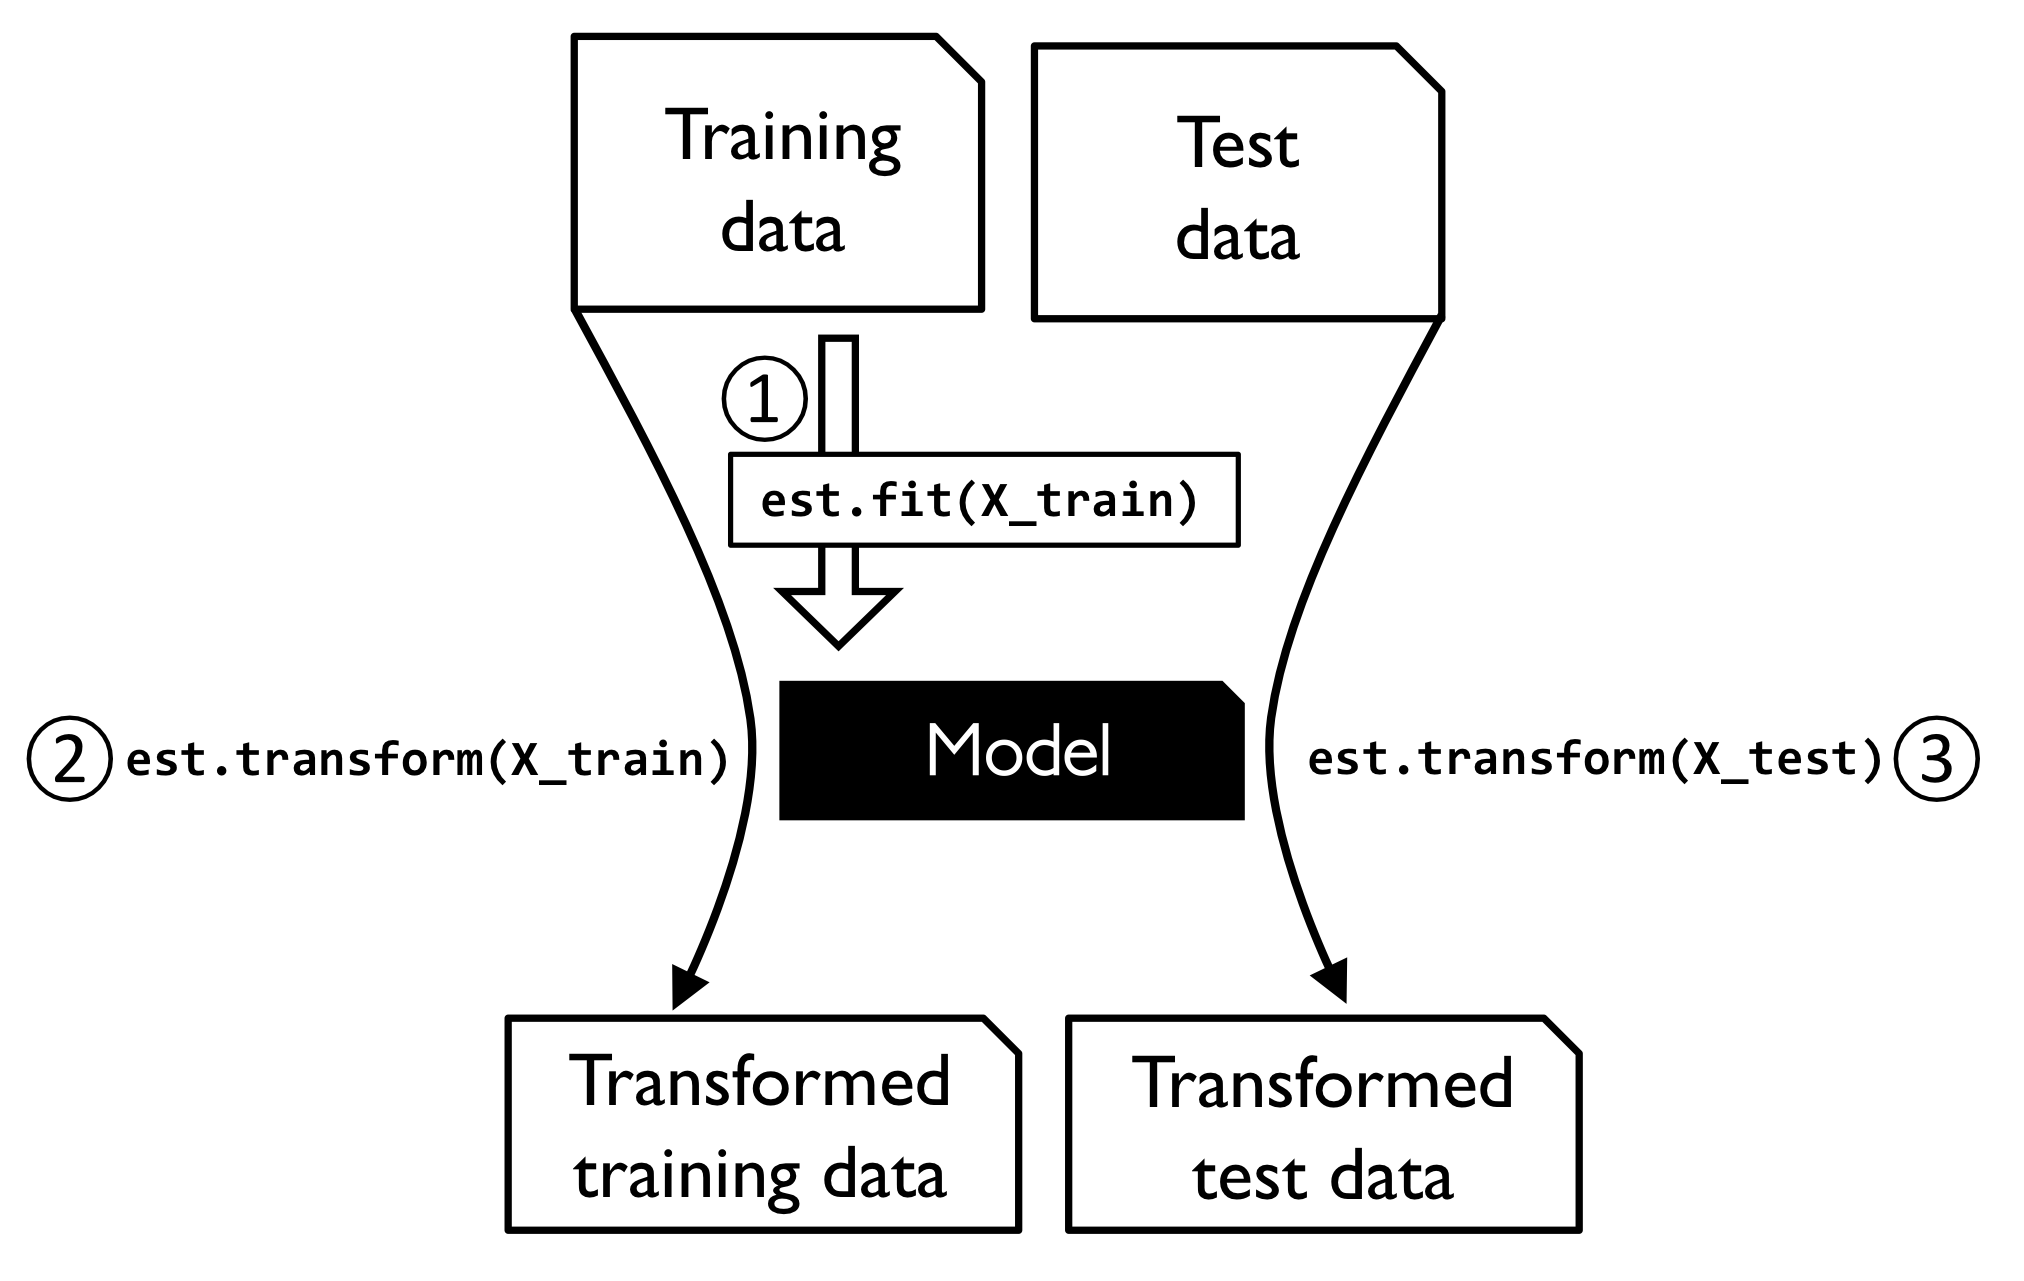

In [11]:
from IPython.display import Image

Image('images/04_01.png', width=300)

我们在第3章中所涉及的分类器就属于所谓的scikit-learn估计器，该API在概念上与转换器类非常相似。估计器有一个`predict`方法，但也可能有一个`transform`方法，在本章稍后部分你会看到。你可能还记得，在训练估计器进行分类时，我们也曾调用`fit`方法来学习模型的参数。然而，在监督学习任务中，我们为拟合模型额外提供了分类标签，它们能用于通过`predict`方法对新数据样本进行预测，如下图所示。

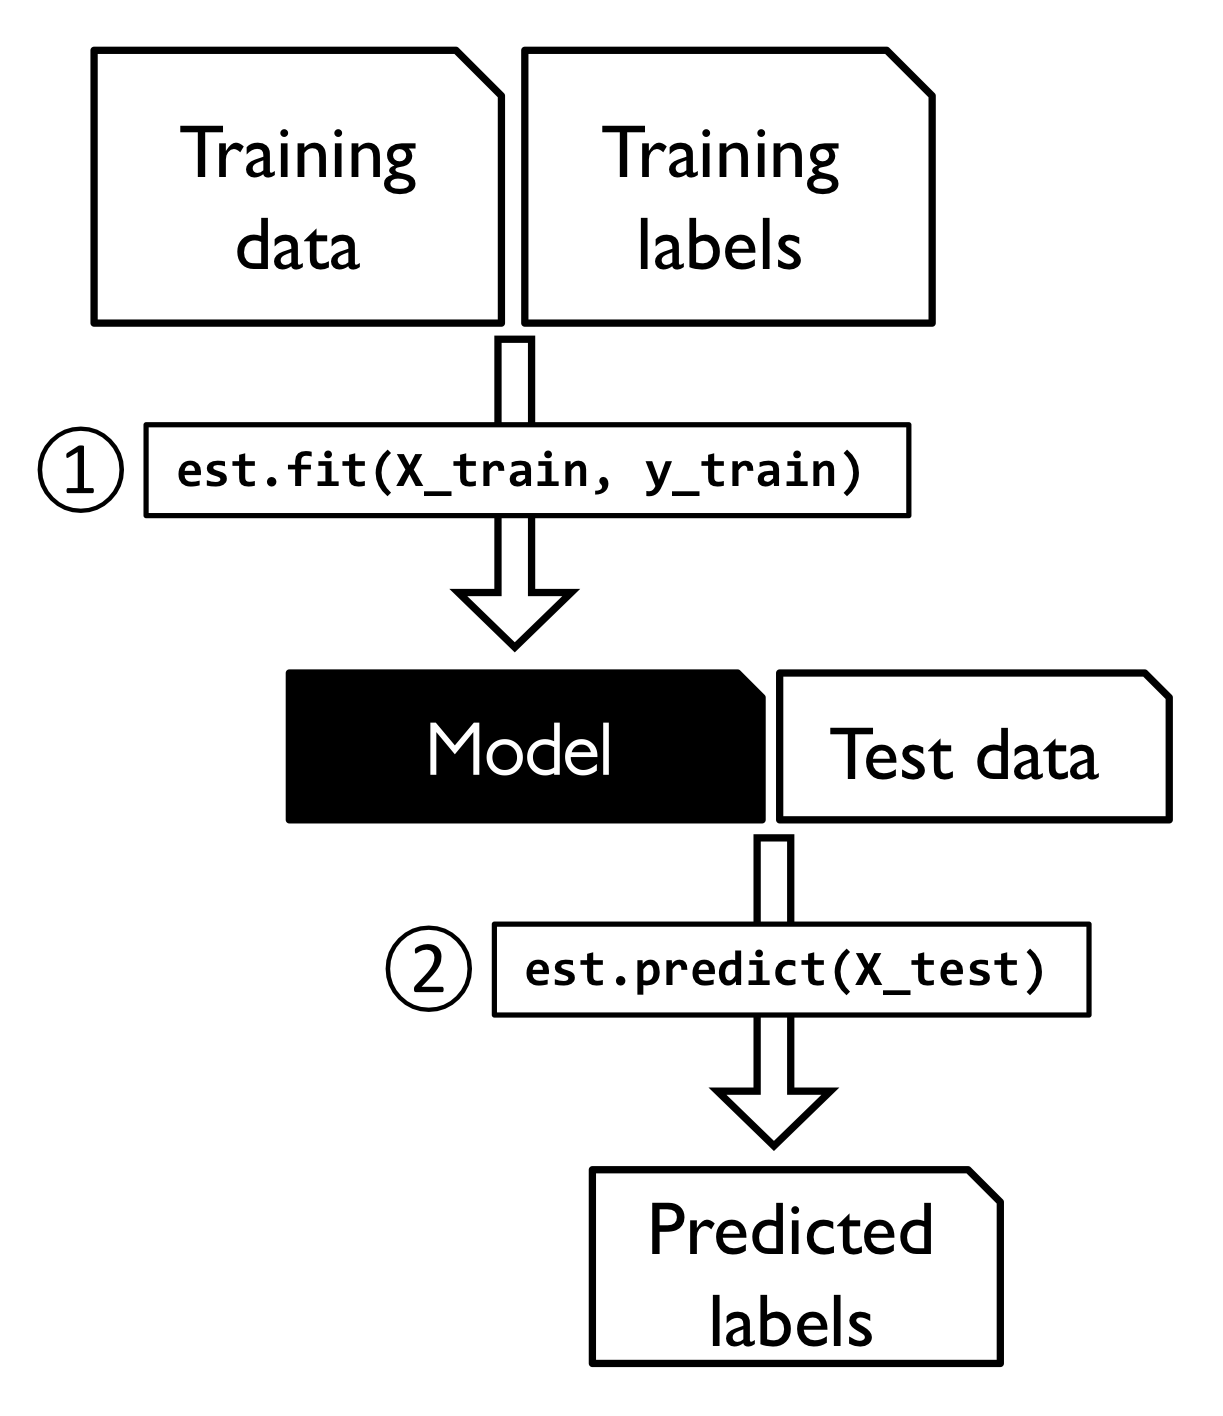

In [12]:
Image('images/04_02.png', width=300)

## 4.2　处理类别数据
到目前为止只研究了数值特征。然而，现实世界中含一个或多个类别特征列的数据集并不少见。我们将在本节以简单而有效的示例来讨论如何用数值计算库处理这类数据。

在讨论类别数据时，我们必须进一步区分序数（ordinal）特征和标称（nominal）特征。序数特征可以理解为可以排序的类别值。例如，T恤尺寸是一个有序特征，因为我们可以定义XL>L>M。相反，标称特征并不蕴涵任何顺序，例如T恤的颜色是标称特征，因为说红色比蓝色大没有什么意义。

### 4.2.1　用pandas实现类别数据的编码
在探讨处理这样的类别数据的不同技术之前，让我们创建一个新的DataFrame来说明这个问题：

In [13]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


从前面的输出可以看到，新创建的DataFrame包含一个标称特征（`color`）列、一个序数特征（`size`）列和一个数值特征（`price`）列。分类标签存储在最后一列。

### 4.2.2　映射序数特征
为了确保机器学习算法能够正确地解读序数特征，我们需要将类别字符串值转换为整数。不幸的是，没有方便函数可以自动导出size特征标签的正确顺序，因此需要人工定义映射关系。在下面的简单例子中，假设我们知道特征之间的数值差异，例如XL=L+1=M+2：

In [14]:
size_mapping = {'XL': 3, 'L':2, 'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


如果想在以后再把整数值转换回原来字符串的形式，我们可以简单地定义一个反向映射字典`inv_size_mapping={v: k for k, v in size_mapping.items()}`（类似之前使用过的`size-mapping`字典），然后可以通过pandas的`map`方法用在变换后的特征列上，如下所示：

In [15]:
inv_size_mapping = {v:k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.3　为分类标签编码
许多机器学习库都要求分类标签的编码为整数值。虽然大多数scikit-learn的分类估计器可以在内部实现整数分类标签的转换，但是通过将分类标签作为整数数组能够从技术角度避免某些问题的产生，在实践中这被认为是一个很好的做法。我们可以采用与之前讨论过的序数特征映射相似的方法为分类标签编码。需要记住的是，分类标签并不是有序的，具体哪个整数匹配特定的字符串标签无关紧要。因此，可以从0开始简单地枚举：

In [16]:
import numpy as np

class_mapping = {lable: idx for idx, lable in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

接下来，可以用映射字典将分类标签转换为整数：

In [17]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


可以在字典中反向映射键值对，将转换后的分类标签匹配到原来的字符串，如下所示：

In [18]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


另外，也可以在scikit-learn中非常方便地直接调用`LabelEncoder`类来实现：

In [19]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

请注意，`fit_transform`方法只是分别调用`fit`和`transform`的一种快捷方式，可以使用`inverse_transform`方法将分类的整数型分类标签转换回原来的字符串形式：

In [20]:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

### 4.2.4　为名义特征做独热编码
4.2.2节我们用简单的字典映射方法将序数`size`特征转换为整数。由于scikit-learn分类估计器把分类标签当成无序的标称特征数据进行分类，我们可以用方便的`LabelEncoder`把字符串标签编码为整数。我们可以用类似的方法转换数据集中的标称特征`color`列，所实现的代码如下：

In [21]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

执行上述代码之后，NumPy数组x的第一列现在就有了新的`color`值，其编码格式为：

- blue = 0
- green = 1
- red = 2

如果就此打住，并把数组提供给分类器，那么我们就会犯处理类别数据中最常见的错误。你知道问题所在吗？虽然颜色值并没有任何的特定顺序，但机器学习算法会假设green大于blue、red大于green。尽管该假设并不正确，但是算法仍然可以产生有用的结果。然而这并不是最优的结果。

解决这个问题的常见方案是采用一种被称为独热编码（one-hot encoding）的技巧。该方法背后的逻辑是为标称特征列的每个唯一值创建一个新的虚拟特征。于是将把color特征转换为blue、green和red三个新特征。然后用二进制值表示样本的特定color；例如，一个blue样本可以编码为blue=1，green=0，red=0。我们可以使用scikit-learn的`preprocessing`模块中的`OneHotEncoder`来实现这种转换：

In [22]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

请注意，我们仅将`OneHotEncoder`应用于单列（`X[:,0].reshape(-1, 1)`），以避免再修改数组中的其他两列。如果想要选择性地转换多特征数组中的列，则可以使用`ColumnTransformer`，它接受（`name`, `transformer`, `column(s)`）元组的列表，如下所示：

In [25]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([('onehot', OneHotEncoder(), [0]),
                              ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

在前面的代码示例中，我们通过定义`passthrough`参数指定只修改第一列，而保持其他两列不变。

通过独热编码创建虚拟特征有一个更方便的方法，即使用pandas中实现的`get_dummies`方法。把`get_dummies`方法应用到DataFrame，只转换字符串列，而保持其他所有列不变：

In [27]:
pd.get_dummies(df[['color', 'size', 'price']], dtype=int)

,size,price,color_blue,color_green,color_red
0,1,10.1,0,1,0
1,2,13.5,0,0,1
2,3,15.3,1,0,0


当用独热编码技术为数据集编码时，必须小心它会带来多重共线性，对某些方法来说这可能是个问题（例如那些需要矩阵求逆的方法）。如果特征高度相关那么矩阵求逆是很难计算的，这可能会导致数值估计不稳定。为了减少变量之间的相关性，可以直接从独热编码数组中删除一个特征列。请注意，尽管我们删除了一个特征列，但并没失去任何重要的信息。例如，如果删除`color_blue`列，那么特征信息仍然可以得到保留，因为如果我们观察到`color_green=0`和`color_red=0`，这意味着余下的观察结果一定是`blue`。

在调用`get_dummies`函数时，可以通过给`drop_first`传递`True`参数来删除第一列，如下面的代码示例所示：

In [28]:
pd.get_dummies(df[['color', 'size', 'price']], dtype=int, drop_first=True)

,size,price,color_green,color_red
0,1,10.1,1,0
1,2,13.5,0,1
2,3,15.3,0,0


如果要用独热编码方法删除冗余列，我们就需要定义`drop='first'`，并设置`categories='auto'`，如下所示：

In [29]:
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([('onehot', color_ohe, [0]),
                              ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

**可选项：序数特征编码**

如果我们不确定序数特征类别之间的数值差异，或者未定义两个序数值之间的差异，我们可以使用0/1阈值对它们进行编码。例如我们可以将具有M、L和XL值的特征`size`拆分为两个新特征，即“x>M”和“x>L”。让我们考虑原始DataFrame：

In [30]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


我们可以用pandas DataFrame的`apply`方法编写自定义的`lambda`表达式，以便调用`value-threshold`方法对这些变量进行编码：

In [31]:
df['x>M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x>L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)
del df['size']
df

,color,price,classlabel,x>M,x>L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


## 4.3　把数据集划分为独立的训练数据集和测试数据集
在第1章和第3章中，我们简要地介绍了把数据集划分成独立的训练数据集和测试数据集的概念。记住，比较预测值与测试数据集的真值，可以理解为对模型所做的无偏置性能评估，然后再将其放到现实世界。本节将创建一个新数据集，即葡萄酒（Wine）数据集。在对数据集进行预处理后，我们再进一步探索用于数据集降维的不同特征选择技术。

葡萄酒数据集是另一个开源数据集，读者可以从UCI的机器学习资源库（[https://archive.ics.uci.edu/ml/datasets/Wine](https://archive.ics.uci.edu/ml/datasets/Wine)）获得；该数据集包含了有13个特征的178个葡萄酒样本，从不同角度对各个化学特性进行了描述。

**获取葡萄酒数据集**

读者可以在本书的代码包（[https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data)）中找到葡萄酒数据集（以及本书用到的其他数据集），以备在脱机工作或者UCI服务器暂时不可用时使用，如果要从本地目录加载葡萄酒数据集，可以将下面这行

```python
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
```

替换为：

```python
df = pd.read_csv('your/local/path/to/wine.data', header=None)
```

可以直接用pandas库从UCI的机器学习资源库读入开源的葡萄酒数据集：

In [32]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [33]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


上表列出了葡萄酒数据集的13个特征，描述178个葡萄酒样本的化学性质。

这些样本来自1、2和3类葡萄酒，分别对应意大利同一地区种植的三种不同品种的葡萄，如数据集摘要中所描述的那样（[https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names)）。

把数据集随机划分成独立的训练数据集和测试数据集的一个便捷方法是，从scikit-learn的`model_selection`子模块调用`train_test_split`函数：